In [89]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import time


#define plotting style that I like
style.use('seaborn-deep')

In [90]:
#define constants
m_p=938.27231 #MeV
m_n=939.56563 #MeV
hbar_c=197.327053 #MeVfm

In [91]:
np_total=pd.read_csv('CSV_files/np.dat.csv')
pp_total=pd.read_csv('CSV_files/pp.dat.csv')
pp_total.rename(columns={' scattering_angle': 'scattering_angle', ' experimental_value': 'experimental_value', ' statistical_error': 'statistical_error', ' reaction_type': 'reaction_type', ' observable': 'observable', ' systematic_error': 'systematic_error', ' normalization': 'normalization'}, inplace=True)
np_total.rename(columns={' scattering_angle': 'scattering_angle', ' experimental_value': 'experimental_value', ' statistical_error': 'statistical_error', ' reaction_type': 'reaction_type', ' observable': 'observable', ' systematic_error': 'systematic_error', ' normalization': 'normalization'}, inplace=True)

In [92]:
# read separated files
#np files
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')

#pp files
pp_sgt=pd.read_csv('CSV_files/pp.sgt.csv')
pp_sgtt=pd.read_csv('CSV_files/pp.sgtt.csv')

In [93]:
#remove uneccesary columns
#remove scattering angle because they are all 0 for sgt and sgtt
#total files
pp_total = pp_total.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization', 'reaction_type', 'observable'])
np_total = np_total.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization', 'reaction_type', 'observable'])
#np files
np_sgt = np_sgt.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization', 'reaction_type', 'observable'])
np_sgtt = np_sgtt.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization', 'reaction_type', 'observable'])
#pp files
pp_sgt = pp_sgt.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization', 'reaction_type', 'observable'])
pp_sgtt = pp_sgtt.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization', 'reaction_type', 'observable'])

In [94]:
# fucntions for k for each rxn type
def k_pp(energy):
    value=np.sqrt(((m_p**2)*(energy)*(energy+2*m_n))/(((m_p+m_n)**2)+(2*energy*m_p))) 
    k_pp=value/hbar_c 
    return k_pp
def k_np(energy):
    value=np.sqrt((1/2)*m_p*energy) 
    k_np=value/hbar_c 
    return k_np

In [95]:
# add k*experimental_value column
def change_np(rxn_observable):
    rxn_observable['K*experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_np(row.energy)),axis=1)
def change_pp(rxn_observable):
    rxn_observable['K*experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_pp(row.energy)),axis=1)

In [96]:
#define runtime calculator
def timer(elapsed_time):
    seconds = (time.time() - elapsed_time)
    day = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    seconds = seconds
    print('')
    print('Cell runtime:', "%s days, %s hours, %s minutes, %s seconds" % (day, hour, minutes, seconds) )
    print('')

In [97]:
change_np(np_sgt)
change_np(np_sgtt)
change_pp(pp_sgt)
change_pp(pp_sgtt)

In [98]:
np_sgt = np_sgt.drop(columns=['experimental_value'])
np_sgtt = np_sgtt.drop(columns=['experimental_value'])
pp_sgt = pp_sgt.drop(columns=['experimental_value'])
pp_sgtt = pp_sgtt.drop(columns=['experimental_value'])

In [99]:
np_sgtt

,energy,K*experimental_value
0,3.650000,53.202216
1,4.420000,10.315291
2,4.910000,9.972118
3,5.210000,-9.595784
4,5.810000,-6.826068
5,6.250000,-18.138622
6,7.430000,-38.596413
7,9.570000,-46.757656
8,11.600000,-55.030014
9,10.700000,-50.410591


# Random Forests

In [100]:
def split_and_score(size, number_of_random_states):
    test=np.zeros(number_of_random_states)
    train=np.zeros(number_of_random_states)
    for j in range(number_of_random_states):
        #split
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=size)
        #rf.train
        rf = RandomForestRegressor(n_estimators=1000)
        rf.fit(train_features, train_labels);
        predictions = rf.predict(test_features)
        rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)
        importances = list(rf.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        #score
        test[j]=rf.score(test_features,test_labels)
        train[j]=rf.score(train_features,train_labels)
    test_ave=np.mean(test)
    train_ave=np.mean(train)
    test_var=np.sqrt(np.var(test))
    train_var=np.sqrt(np.var(train))
    return test_ave, test_var, train_ave, train_var

## Variables to change for random forests

In [101]:
## EVERYTHING THAT NEEDS CHANGED SHOULD BE IN HERE

#define number of random states
number_of_random_states=5

#define intervals of test size
intervals=9 # 1:50%, 3:25%, 4:20%, 9:10%, 19:5%, 24:4%, 49:2%, 99:1%

In [102]:
#x-axis
if intervals==1:
    sample_size=[50] #50% intervals
elif intervals==3:
    sample_size=list(range(25,76,25)) #25% intervals
elif intervals==4:
    sample_size=list(range(20,81,20)) #20% intervals 
elif intervals==9:
    sample_size=list(range(10,91,10)) #10% intervals
elif intervals==19:
    sample_size=list(range(5,96,5)) #5% intervals
elif intervals==24:
    sample_size=list(range(4,97,4)) #4% intervals
elif intervals==49:
    sample_size=list(range(2,99,2)) #2% intervals
elif intervals==99:
    sample_size=list(range(1,100,1)) #1% intervals

In [103]:
def train_and_plot(rxn_observable, reac_observ):
    #start timer
    rxn_observable_time = time.time()
    # One-hot encode categorical features
    rxn_observable_plot = pd.get_dummies(rxn_observable)
    # Labels are the values we want to predict
    labels = np.array(rxn_observable_plot['K*experimental_value'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    features = rxn_observable_plot.drop('K*experimental_value', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    rxn_observable_test_mean=np.zeros(intervals) 
    rxn_observable_train_mean=np.zeros(intervals) 
    rxn_observable_test_variance=np.zeros(intervals) 
    rxn_observable_train_variance=np.zeros(intervals) 
    for i in range(intervals): 
        #define size
        size=(i+1)/(intervals+1)
        #call split function
        test, test_v, train, train_v = split_and_score(size, number_of_random_states)
        #add to arrays
        rxn_observable_test_mean[i]=test
        rxn_observable_train_mean[i]=train
        rxn_observable_test_variance[i]=test_v
        rxn_observable_train_variance[i]=train_v
    print("Average Testing Score:", rxn_observable_test_mean)
    print('Testing Variance', rxn_observable_test_variance)
    print('')
    print('Average Training Score', rxn_observable_train_mean)
    print('Training Variance', rxn_observable_train_variance)
    print('')

    #plot 

    #figure
    figure(figsize=(15, 5))
    ax=plt.subplot(111)
    plt.xlabel('Test Size (%)')
    plt.ylabel('Score')
    plt.title("Reaction_Observable: {}".format(reac_observ))
    plt.xlim(left=0, right=100)
    ax.scatter(sample_size, rxn_observable_test_mean, s=100, label='Average Testing Score')
    ax.scatter(sample_size, rxn_observable_train_mean, s=100, label='Average Training Score')
    ax.errorbar(sample_size, rxn_observable_test_mean, yerr=rxn_observable_test_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.errorbar(sample_size, rxn_observable_train_mean, yerr=rxn_observable_train_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.legend(loc='best')
    plt.show

    #print elapsed time
    timer(rxn_observable_time)

### NP SGT

Average Testing Score: [-4.94009300e+02  4.81159255e-01  6.25101869e-01  7.65165928e-01
  6.36553398e-01  5.45672894e-01  2.24991204e-02  1.44457475e-02
 -3.14279860e-01]
Testing Variance [9.82266040e+02 5.60549182e-01 1.96730331e-01 1.18127158e-01
 1.44776602e-01 2.41843608e-01 7.21339713e-01 1.41039011e-01
 4.18490181e-01]

Average Training Score [0.96460936 0.95845301 0.96992964 0.94709363 0.93330893 0.93546064
 0.89470481 0.79463691 0.        ]
Training Variance [0.00503915 0.00642715 0.01013283 0.02263619 0.01323496 0.01149513
 0.0458377  0.06142952 0.        ]


Cell runtime: 0.0 days, 0.0 hours, 0.0 minutes, 36.052618980407715 seconds



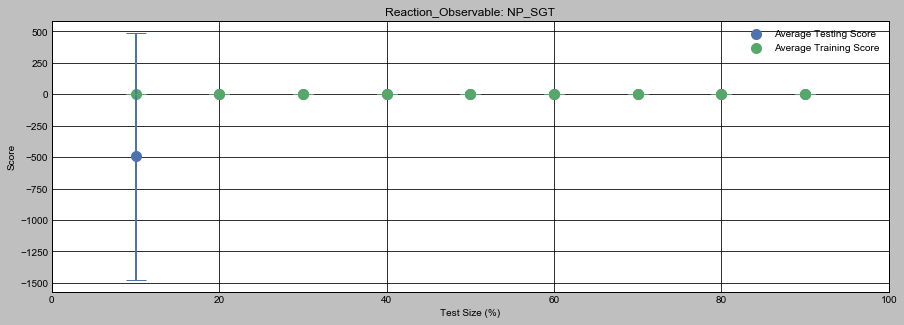

In [104]:
train_and_plot(np_sgt, "NP_SGT")

### NP SGTT

Average Testing Score: [-0.24819162  0.64662978  0.75183323  0.60394026  0.67841985  0.46250553
 -0.23128964 -0.39630037 -1.59949729]
Testing Variance [1.65286226 0.14685621 0.09839949 0.20657859 0.07724609 0.22932448
 0.71941231 0.32701765 0.95091521]

Average Training Score [0.9599561  0.96837976 0.95752505 0.95084555 0.94348251 0.91581277
 0.89721914 0.79354662 0.        ]
Training Variance [0.00346696 0.00868281 0.00610194 0.01112978 0.01885803 0.03066025
 0.05268023 0.05369486 0.        ]


Cell runtime: 0.0 days, 0.0 hours, 0.0 minutes, 35.33504104614258 seconds



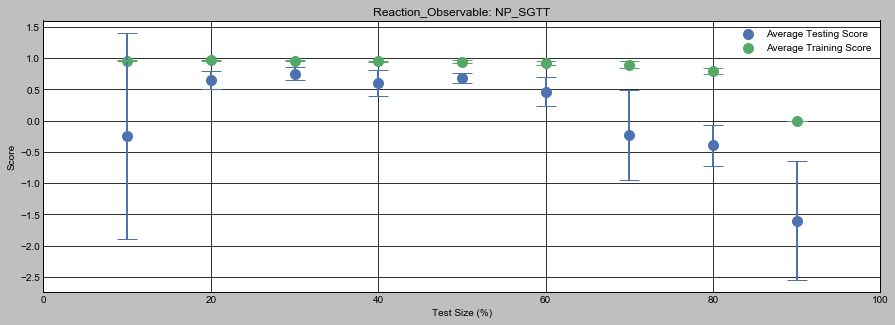

In [105]:
train_and_plot(np_sgtt, "NP_SGTT")

### Calculate values for a and b from predicted data

In [110]:
#start timer
ab_time = time.time()

E = np.linspace(0, 350, 350/5)
E = E.reshape(-1,1)

# NP_SGT
# One-hot encode categorical features
np_sgt_ab = pd.get_dummies(np_sgt)
# Labels are the values we want to predict
labels = np.array(np_sgt_ab['K*experimental_value'])
# Remove the labels from the features
# axis 1 refers to the columns
features = np_sgt_ab.drop('K*experimental_value', axis = 1)
#split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25)
#rf.train
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(train_features, train_labels);
np_sgt_predict = rf.predict(E) 


# NP_SGTT
# One-hot encode categorical features
np_sgtt_ab = pd.get_dummies(np_sgtt)
# Labels are the values we want to predict
labels = np.array(np_sgtt_ab['K*experimental_value'])
# Remove the labels from the features
# axis 1 refers to the columns
features = np_sgtt_ab.drop('K*experimental_value', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)
#split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25)
#rf.train
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(train_features, train_labels);
np_sgtt_predict = rf.predict(E)
    
timer(ab_time)

/Users/stevebradley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.



Cell runtime: 0.0 days, 0.0 hours, 0.0 minutes, 1.6194360256195068 seconds



In [111]:
#SGT: k*experimental_value=20*pi*IM(a+b)
#SGTT: k*experimental_value=-40*pi*IM(a-b)
# [1  1] [a] = [sgt /( 20pi)] ==> system solved by hand ==> [a] = [1/2   1/2] [sgt /( 20pi)]
# [1 -1] [b] = [sgtt/(-40pi)]                               [b] = [1/2  -1/2] [sgtt/(-40pi)]
    


Cell runtime: 0.0 days, 0.0 hours, 0.0 minutes, 0.1294701099395752 seconds



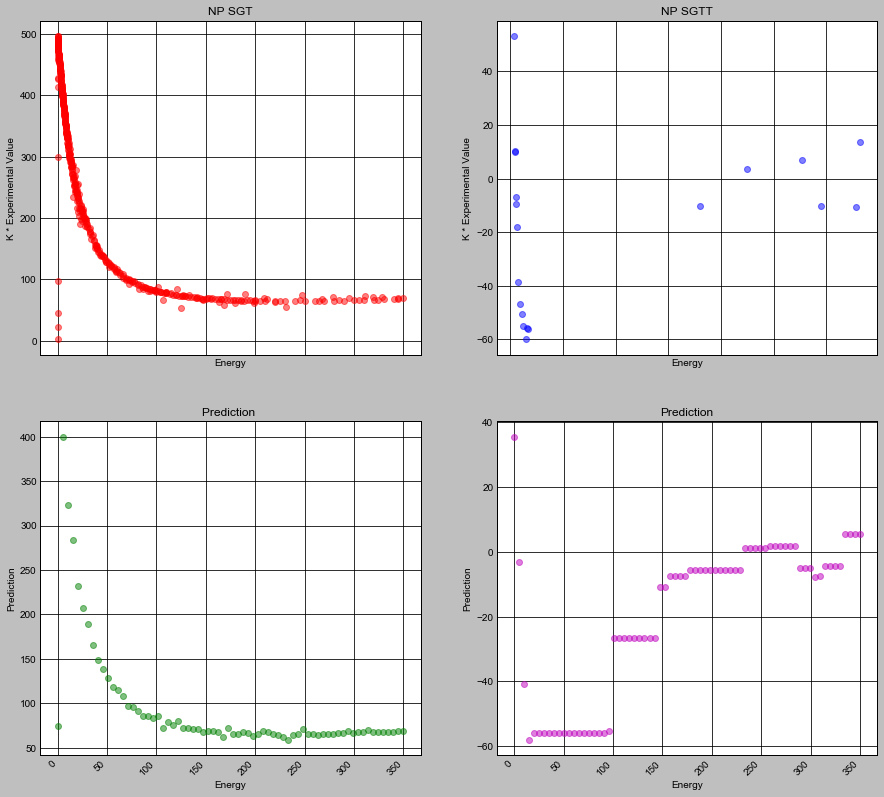

In [112]:
plot_time=time.time()
#define values to be plotted
sgt_energy=np_sgt['energy']
sgt_k_value=np_sgt['K*experimental_value']
sgtt_energy=np_sgtt['energy']
sgtt_k_value=np_sgtt['K*experimental_value']
#figure specifications
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,15))
fig.autofmt_xdate(rotation = 45)
#plot 1
ax1.plot(sgt_energy, sgt_k_value, 'ro', alpha=0.5)
ax1.set_xlabel('Energy'); ax1.set_ylabel('K * Experimental Value'); ax1.set_title('NP SGT')
#plot 2
ax2.plot(sgtt_energy, sgtt_k_value, 'bo', alpha=0.5)
ax2.set_xlabel('Energy'); ax2.set_ylabel('K * Experimental Value'); ax2.set_title('NP SGTT')
#plot 3
ax3.plot(E, np_sgt_predict, 'go', alpha=0.5)
ax3.set_xlabel('Energy'); ax3.set_ylabel('Prediction'); ax3.set_title('Prediction ')
#plot 4
ax4.plot(E, np_sgtt_predict, 'mo', alpha=0.5)
ax4.set_xlabel('Energy'); ax4.set_ylabel('Prediction'); ax4.set_title('Prediction')

timer(plot_time)

Text(0.5, 1.0, 'Prediction')

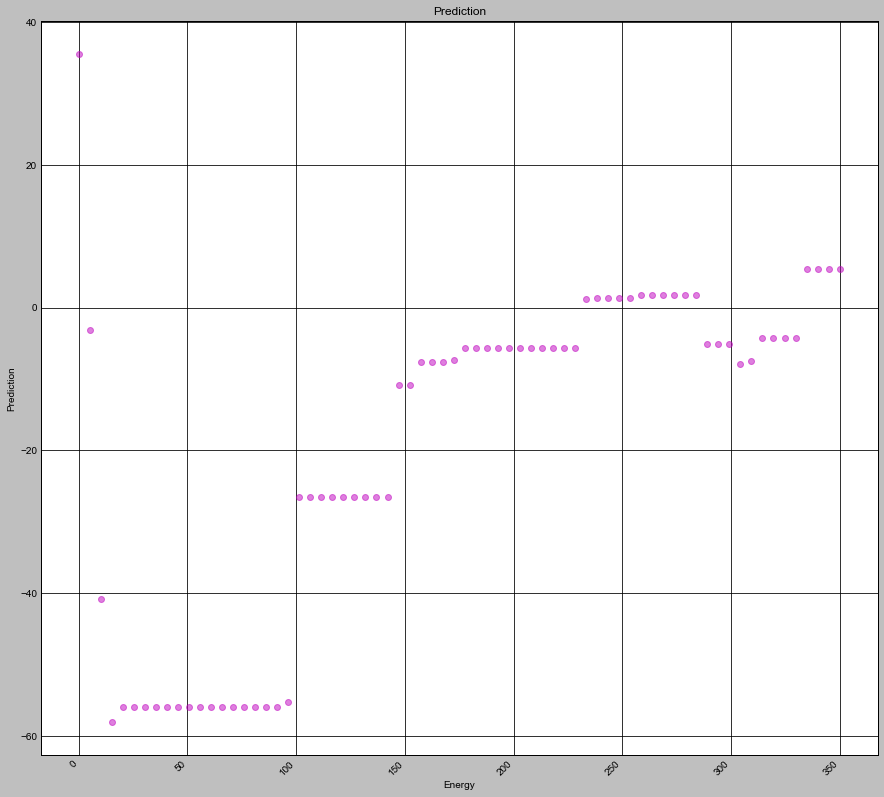

In [113]:
fig, (ax4) = plt.subplots(nrows=1, ncols=1, figsize = (15,15))
fig.autofmt_xdate(rotation = 45)
#plot 4
ax4.plot(E, np_sgtt_predict, 'mo', alpha=0.5)
ax4.set_xlabel('Energy'); ax4.set_ylabel('Prediction'); ax4.set_title('Prediction')